# Allen-Cahn equation
## Problem setup

We will solve an Allen-Cahn equation:
$$
\frac{\partial u}{\partial t}=d \frac{\partial^2 u}{\partial x^2}+5\left(u-u^3\right), \quad x \in[-1,1], \quad t \in[0,1]
$$

The initial condition is defined as the following:
$$
u(x, 0)=x^2 \cos (\pi x)
$$

And the boundary condition is defined:
$$
u(-1, t)=u(1, t)=-1
$$

## Implementation

This description goes through the implementation of a solver for the above described Allen-Cahn equation step-by-step.

In [1]:
import deepxde as dde
import numpy as np
from scipy.io import loadmat
# Import tf if using backend tensorflow.compat.v1 or tensorflow
# from deepxde.backend import tf
# Import torch if using backend pytorch
import torch


No backend selected.
Finding available backend...


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Found pytorch
Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [2]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Now, we express the PDE residual of the Allen-Cahn equation:

In [3]:
d = 0.001
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - d * dy_xx - 5 * (y - y**3)

The first argument to pde is a 2-dimensional vector where the first component(x[:, 0]) is 
$x$-coordinate and the second component (x[:, 1]) is the 
$t$-coordinate. The second argument is the network output, i.e., the solution $u(x,t)$
, but here we use $y$ as the name of the variable.

Now that we have specified the geometry and PDE residual, we can define the TimePDE problem as the following:

In [4]:
data = dde.data.TimePDE(geomtime, pde, [], num_domain=8000, num_boundary=400, num_initial=800)

## Define NN
Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 20:


In [5]:
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

Next, we consider the initial conditions and boundary constraints, defining the transformation of the output and applying it to the network. In this case, $x^2 \cos (\pi x)+t\left(1-x^2\right) y$ is used. When $t=0$, the initial condition $x^2 \cos (\pi x)$ is satisfied. When $x=11$ or $x=-1$, the boundary condition $y(-1, t)=y(1, t)=-1$ is satisfied. This demonstrates that the initial condition and the boundary constraint are both hard conditions.

In [7]:
def output_transform(x, y):
    return x[:, 0:1]**2 * torch.cos(np.pi * x[:, 0:1]) + x[:, 1:2] * (1 - x[:, 0:1]**2) * y

net.apply_output_transform(output_transform)

In [8]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
model.train(iterations=40000)

Compiling model...
'compile' took 0.000154 s

Training model...

Step      Train loss    Test loss     Test metric
0         [8.23e-01]    [8.23e-01]    []  
1000      [9.09e-02]    [9.09e-02]    []  
2000      [1.65e-02]    [1.65e-02]    []  
3000      [1.16e-02]    [1.16e-02]    []  
4000      [9.70e-03]    [9.70e-03]    []  
5000      [8.60e-03]    [8.60e-03]    []  
6000      [7.87e-03]    [7.87e-03]    []  
7000      [7.27e-03]    [7.27e-03]    []  
8000      [6.81e-03]    [6.81e-03]    []  
9000      [6.62e-03]    [6.62e-03]    []  
10000     [6.17e-03]    [6.17e-03]    []  
11000     [5.92e-03]    [5.92e-03]    []  
12000     [5.74e-03]    [5.74e-03]    []  
13000     [5.55e-03]    [5.55e-03]    []  
14000     [5.39e-03]    [5.39e-03]    []  
15000     [5.27e-03]    [5.27e-03]    []  
16000     [5.17e-03]    [5.17e-03]    []  
17000     [5.08e-03]    [5.08e-03]    []  
18000     [4.99e-03]    [4.99e-03]    []  
19000     [4.91e-03]    [4.91e-03]    []  
20000     [4.83e-03]    [

(<deepxde.model.LossHistory at 0x7f6af0cd0160>,
 <deepxde.model.TrainState at 0x7f6af0cd09a0>)

In [9]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000980 s

Training model...

Step      Train loss    Test loss     Test metric
40000     [7.41e-04]    [7.41e-04]    []  
41000     [2.01e-04]    [2.01e-04]    []  
42000     [9.87e-05]    [9.87e-05]    []  
43000     [6.74e-05]    [6.74e-05]    []  
44000     [4.74e-05]    [4.74e-05]    []  
45000     [3.55e-05]    [3.55e-05]    []  
46000     [2.77e-05]    [2.77e-05]    []  
47000     [2.19e-05]    [2.19e-05]    []  
48000     [1.70e-05]    [1.70e-05]    []  
49000     [1.37e-05]    [1.37e-05]    []  
50000     [1.20e-05]    [1.20e-05]    []  
51000     [1.20e-05]    [1.20e-05]    []  
52000     [1.20e-05]    [1.20e-05]    []  
53000     [1.19e-05]    [1.19e-05]    []  
54000     [1.19e-05]    [1.19e-05]    []  
55000     [1.19e-05]    [1.19e-05]    []  

Best model at step 55000:
  train loss: 1.19e-05
  test loss: 1.19e-05
  test metric: []

'train' took 285.696220 s



Saving loss history to /home/liyang/Desktop/Code_Sep/NN_PDE_summary/PINNs/1D/AC/loss.dat ...
Saving training data to /home/liyang/Desktop/Code_Sep/NN_PDE_summary/PINNs/1D/AC/train.dat ...
Saving test data to /home/liyang/Desktop/Code_Sep/NN_PDE_summary/PINNs/1D/AC/test.dat ...


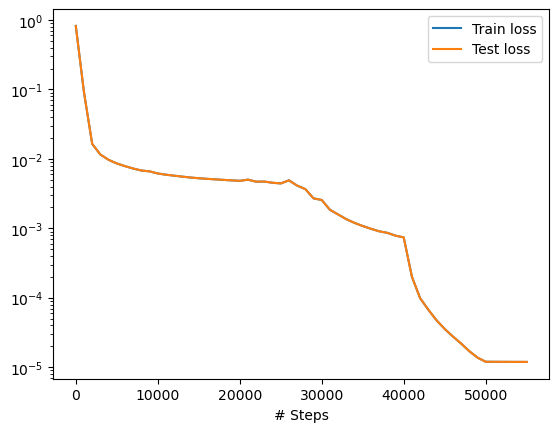

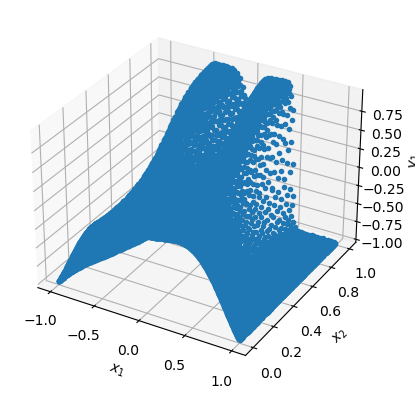

In [10]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [11]:

t=np.linspace(0,1,101)
x=np.linspace(-1.,1.,201)
xx, tt = np.meshgrid(x, t)
X = np.vstack((np.ravel(xx), np.ravel(tt))).T

y_pred = model.predict(X)
# np.save('AC_PINN',y_pred)

In [12]:
import matplotlib.pyplot as plt

Text(0, 0.5, 't')

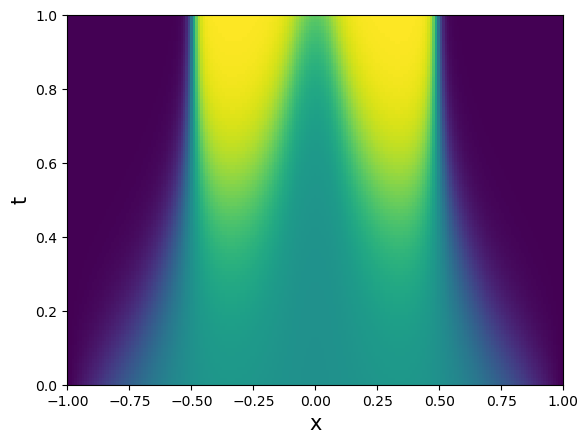

In [26]:
extend = [-1, 1, 0, 1]
# plt.figure(figsize=(20, 4.355))
# plt.subplot(111)

plt.imshow(y_pred.reshape(101,201), interpolation='nearest', cmap='viridis',
               extent=extend, origin='lower', aspect='auto')
plt.xlabel('x', fontsize=15)
plt.ylabel('t', fontsize=15)
# plt.title("t="+str(step*dt), fontsize=20)
# plt.clim(-1, 1)
# plt.axis('equal')